In [14]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

# Wczytanie danych, stworzenie ramki danych i usunięcie spacji z nazw kolumn
df = pd.read_csv('messy_data.csv')
df.columns = df.columns.str.strip()

In [15]:
# Zmiana typów danych na float i wypełnienie brakujących danych  wartością średnią dla tej kolumny
columns_to_convert = ['carat', 'x dimension', 'y dimension', 'z dimension', 'depth', 'table', 'price']
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df[column].fillna(df[column].mean(), inplace=True)

In [16]:
df = df.drop_duplicates()

In [17]:
# Identyfikacja wartości odstających i filtrowanie
df_numeric = df.select_dtypes(include=[np.number])
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
filter = ~((df_numeric < (Q1 - 1.75 * IQR)) | (df_numeric > (Q3 + 1.75 * IQR))).any(axis=1)
df = df[filter]

In [20]:
# Normalizacja wartości kolumny 'clarity', 'color', 'cut'
df.loc[:, 'clarity'] = df['clarity'].str.upper().str.strip()
df.loc[:, 'color'] = df['color'].str.upper().str.strip()
df.loc[:, 'cut'] = df['cut'].str.capitalize().str.strip()

In [22]:
# Zapisanie oczyszczonych danych do nowego pliku
df.to_csv('clean_data.csv', index=False)

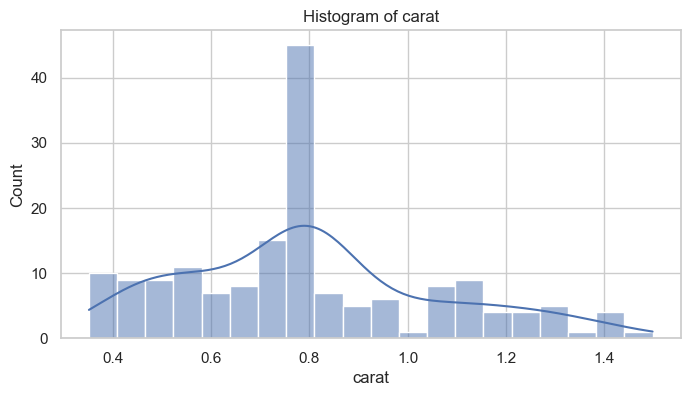

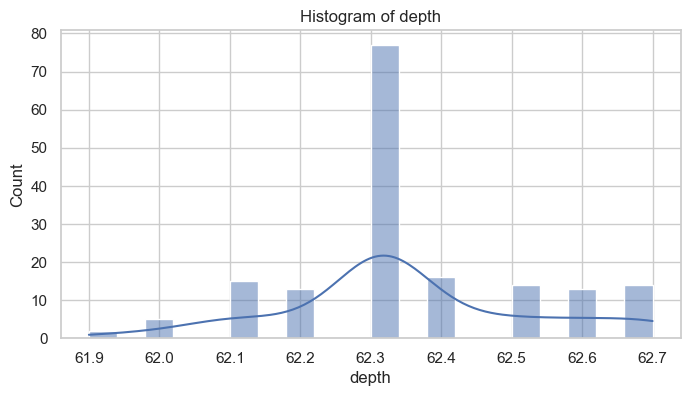

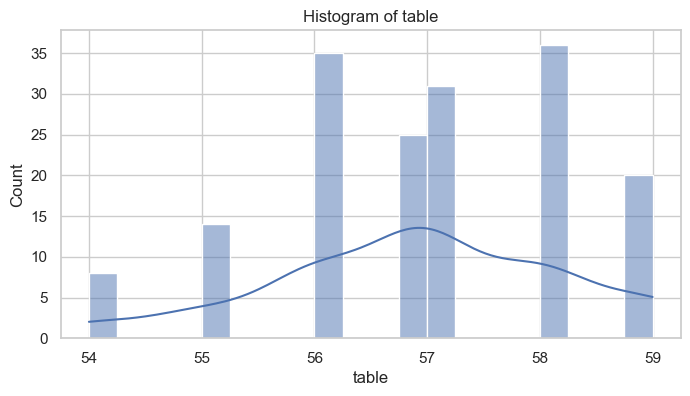

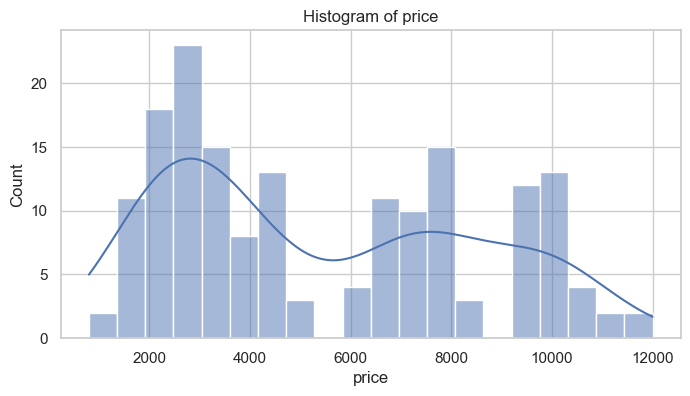

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")

# Tworzenie histogramów dla zmiennych numerycznych

sns.set(style="whitegrid")
num_columns = ['carat', 'depth', 'table', 'price'] 
for col in num_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Histogram of {col}')
    plt.show()

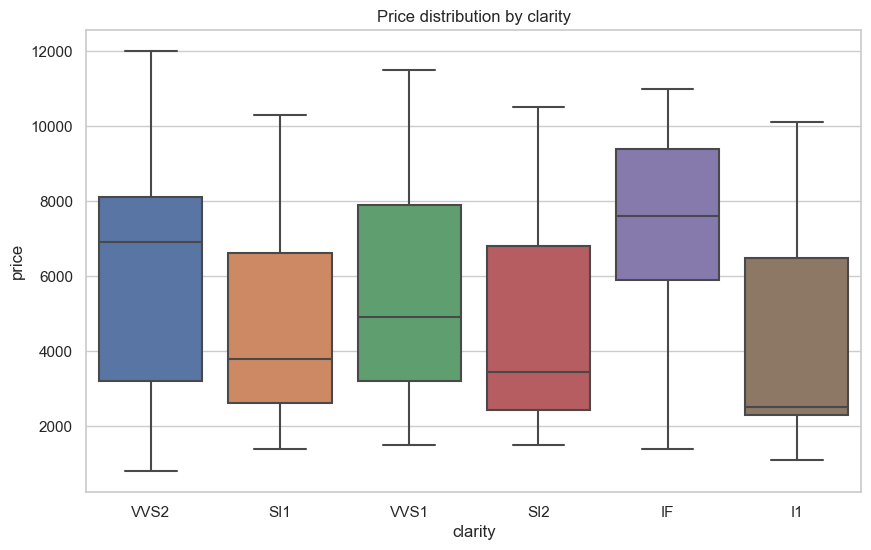

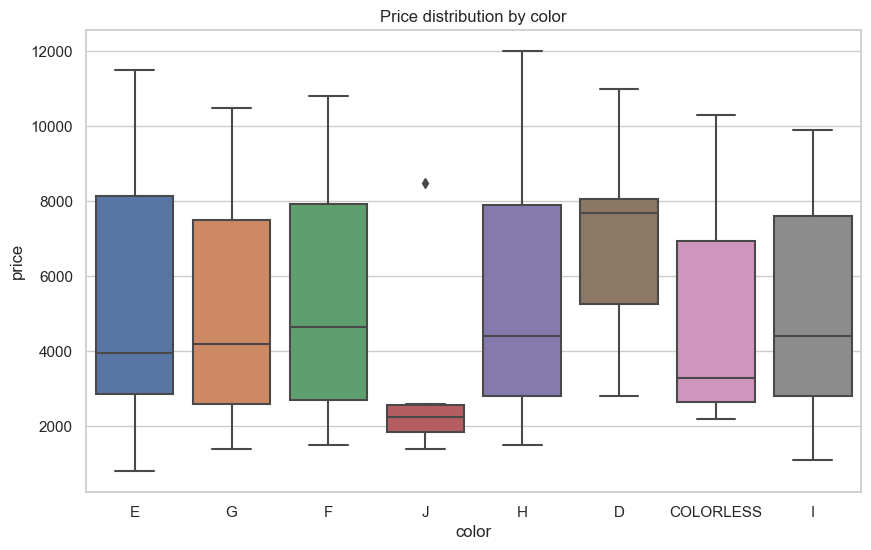

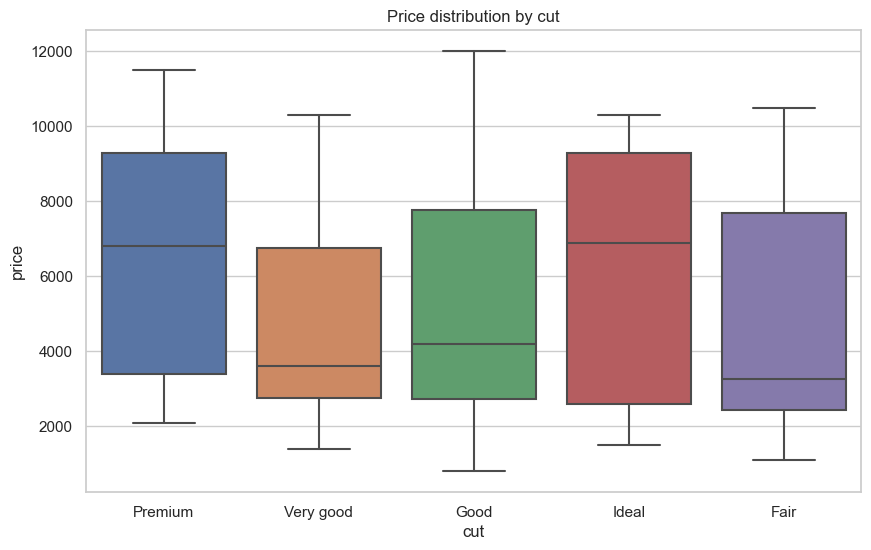

In [30]:
# Wykresy pudełkowe dla zmiennych kategorycznych
cat_columns = ['clarity', 'color', 'cut']  
for col in cat_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='price', data=df)
    plt.title(f'Price distribution by {col}')
    plt.show()

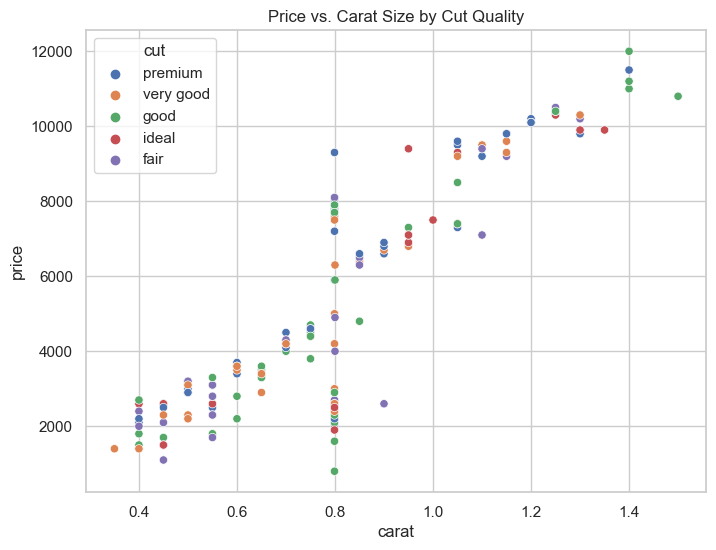

In [8]:
# Wykresy rozrzutu dla zależności między zmiennymi
plt.figure(figsize=(8, 6))
sns.scatterplot(x='carat', y='price', data=df, hue='cut')
plt.title('Price vs. Carat Size by Cut Quality')
plt.show()

In [28]:

# Eliminacja wsteczna, przygotowanie danych i budowa modelu regresji
def backward_elimination(data, target, significance_level=0.05):
    features = data.columns.tolist()
    while len(features) > 0:
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        feature_with_max_p_value = p_values.idxmax()
        if max_p_value > significance_level:
            features.remove(feature_with_max_p_value)
        else:
            break
    return features


X = df.drop(['price'], axis=1)
X = pd.get_dummies(X, drop_first=True)
X = X.select_dtypes(include=[np.number])  
y = df['price']


selected_features = backward_elimination(X, y)

model = sm.OLS(y, sm.add_constant(X[selected_features])).fit()

print(model.summary())




                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     298.2
Date:                Fri, 02 Feb 2024   Prob (F-statistic):           4.10e-74
Time:                        22:51:45   Log-Likelihood:                -1415.1
No. Observations:                 169   AIC:                             2840.
Df Residuals:                     164   BIC:                             2856.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.901e+04   3769.154     -7.697      

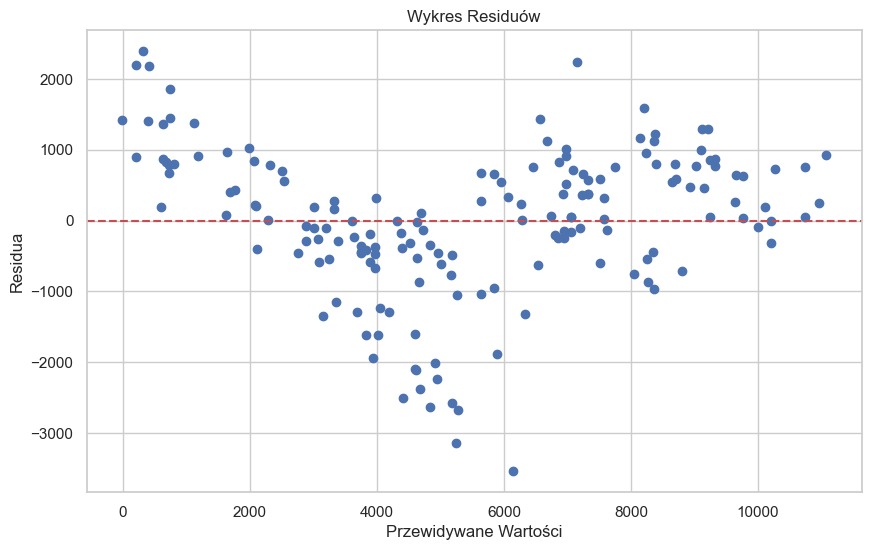

In [26]:
# Wykres reszt
plt.figure(figsize=(10, 6))
predictions = model.predict(sm.add_constant(X[selected_features]))
residuals = y - predictions
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Przewidywane Wartości')
plt.ylabel('Reszty')
plt.title('Wykres Reszt')
plt.show()

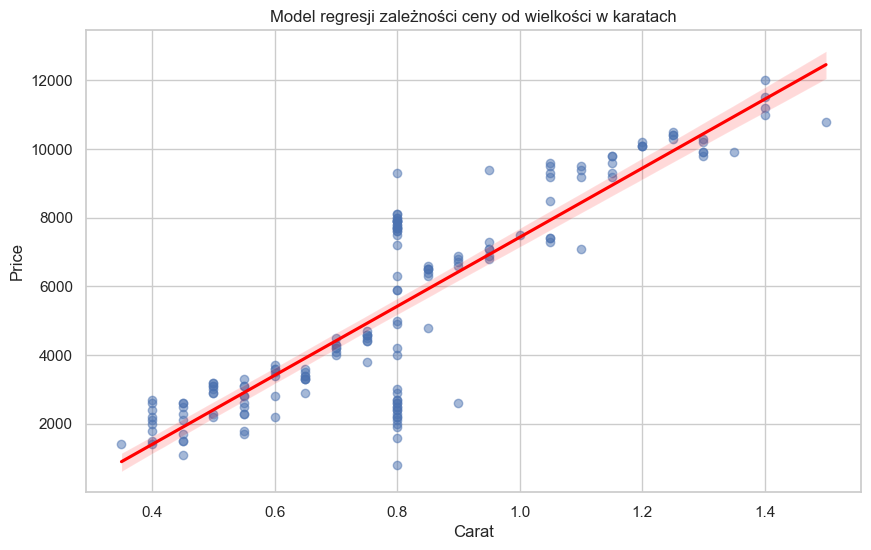

In [31]:
if 'carat' in selected_features:
    plt.figure(figsize=(10, 6))
    sns.regplot(x='carat', y='price', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title('Model regresji zależności ceny od wielkości w karatach')
    plt.xlabel('Carat')
    plt.ylabel('Price')
    plt.show()
    